# Linear least squares fit

Solve the tasks below.
For each task, give reasons for your solution by commenting in the notebook.
In conclusion, summarize your findings and contextualize them. What have you learned? Do the results make sense?

Your results will be examined for plagiarism. Please use your own plot styles, articulate your own thoughts, and present your own experimental approaches.

## Tasks

Perform a least squares fit of a parabola of third order

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3 $$

for the thirteen independent measurments $(x_i, y_i)$ given by $(-1.5, -8.0 \pm 2.5)$, $(-1.25, -2.5 \pm 2.0)$, $(-1.0, -1.5 \pm 1.5)$, $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 0.5)$, $(0.75, 3.0 \pm 1.0)$, $(1.0, 3.0 \pm 1.0)$, $(1.25, 4.5 \pm 1.5)$, $(1.5, 7.0 \pm 2.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Plot the data with a straight-line fit. Determine the $p$-value for this straight-line fit. Is this an acceptable description of the data?

f) How does the $p$-value for a straight-line fit change if the error bars are twice as high in this example? Would you say the fit is describing the data well in this case?


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2, v3: *A = np.column_stack((v0, v1, v2, v3))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from iminuit import Minuit

In [94]:
# data
x = np.array([-1.5,-1.25, -1., -0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])
y = np.array([-8, -2.5, -1.5, 1., 4.0, 4., 5.5, 4.5, 3.5, 3., 3., 4.5, 7.])
sigma_y = np.array([2.5, 2., 1.5, 1, 1, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.5, 2.])
theta_vec=(0,1,2,3)

Fit function which is linear in the parameters: $ f(x, \vec{\lambda}) = \theta_0 + \theta_1 x + \theta_2 x^2 + \theta_3 x^3=\sum a_k(x)\theta_k $, $\vec{\theta}=(\theta_0, \theta_1, \theta_2, \theta_3)$ The $\chi^2$-function reads $\chi^2=(\vec{y}-\mathbf{A}\vec{\theta})^T\mathbf{C}^{-1}(\vec{y}-\mathbf{A}\vec{\theta})$, with $A_{ij}=a_j(x_i)$ the minimum $\chi^2$ solution is: $$\vec{\theta}=(\mathbf{A}^T\mathbf{C}^{-1}\mathbf{A})^{-1}\mathbf{A}^T\mathbf{C}^{-1}\vec{y}=:\mathbf{G}\vec{y}$$
The covariance matrix $\mathbf{C}_{\lambda}=\mathbf{G}\mathbf{C}\mathbf{G}^T=(\mathbf{A}^T\mathbf{C}^{-1}\mathbf{A})^{-1}$

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

In [95]:
j = np.arange(0, len(theta_vec))     # Grad j
A = np.array([x**m for m in j])          # Matrix A mit A_{ij} = x_i^j
A = A.T     # A_ij=a_j(x_i)
#print(A)
C=np.diagflat(sigma_y**2)                   # data independent, matrix diagonal

C_inv = inv(C)                           # Inverse von C
G = inv(A.T @ C_inv @ A) @ A.T @ C_inv
theta = G @ y
C_h=G @ C @ G.T
U=C_h

#print("Matrix G:\n", G)
print("theta:", theta)
print('covariance matrix:', C_h)

theta: [ 4.55056569 -0.43054409 -2.95912686  2.40936812]
covariance matrix: [[ 0.06856352 -0.03260524 -0.06914669  0.02439339]
 [-0.03260524  0.48237957  0.00726321 -0.32047483]
 [-0.06914669  0.00726321  0.24388868 -0.04381973]
 [ 0.02439339 -0.32047483 -0.04381973  0.32929519]]


b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

$\chi^2=\sum_{i=1}^n \frac{y_i-f(x_i, \vec{\lambda})^2}{\sigma_i^2}$,
p-value=$P(\chi_{nF}^2)=1-F(\chi_{nF}^2)$

chi_obs^2= 9.764492802888007
number of degrees of freedom: 9
P-value: 0.36988525356087987


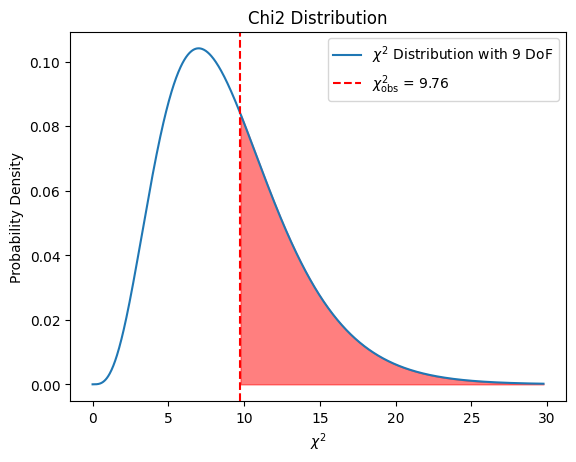

In [96]:
import scipy.stats as stats
chi2_obs = (y - A @ theta).T @ inv(C) @ (y - A @ theta)  #chi2_obs in numpy Array form
chi2_obs = chi2_obs.item()  # Convert to scalar
print('chi_obs^2=',chi2_obs)

dof=len(y)-len(theta)
print('number of degrees of freedom:', dof)

# Chi-squared distribution
x_chi2 = np.linspace(0, chi2_obs + 20, 1000)
chi2_dist = stats.chi2.pdf(x_chi2, dof)   # wahrscheinlichkeitsdichte

#p-value
p_value = 1 - stats.chi2.cdf(chi2_obs, dof)   # wahrscheinlichkeitsveteilung
print('P-value:', p_value)

plt.plot(x_chi2, chi2_dist, label=r'$\chi^2$ Distribution with 9 DoF')
plt.axvline(chi2_obs, color='red', linestyle='--', label=r'$\chi^2_\mathrm{{obs}}$ = {:.2f}'.format(chi2_obs))
plt.fill_between(x_chi2, 0, chi2_dist, where=(x_chi2 >= chi2_obs), color='red', alpha=0.5)   # fill the color to represent the p-value
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability Density')
plt.title('Chi2 Distribution')
plt.legend()
plt.show()

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

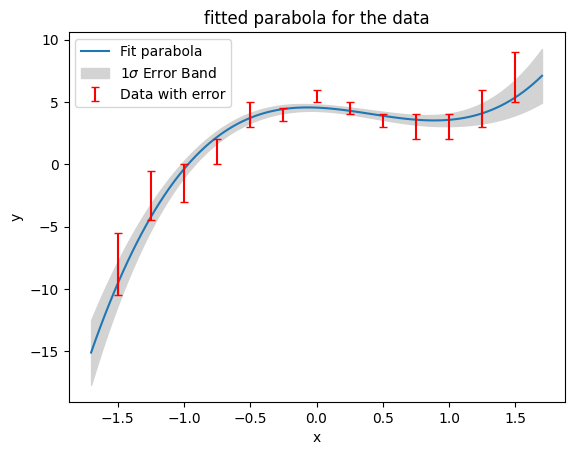

Predicted value at x=1: y = 3.570 ± 0.505


In [97]:
def f(x):     #parabola
    return theta[0]+theta[1]*x+theta[2]*x**2+theta[3]*x**3

x_range=np.linspace(-1.7, 1.7, 100)

# Calculate the uncertainty band (1σ) for each x value in the range
A_range = np.vstack((np.ones_like(x_range), x_range, x_range**2, x_range**3)).T   # ones_like  creates a 1D array of ones that has the same shape as x_range, corresponds constant term in f(x)
dy = np.sqrt(np.sum(A_range @ U * A_range, axis=1))          # U covariance matrix defined above

plt.plot(x_range, f(x_range), label='Fit parabola')
plt.errorbar(x,y, yerr=sigma_y, fmt='None', ecolor='r', capsize=3, marker='s', mec='black', mfc='black', ms='2', label='Data with error')
plt.fill_between(x_range, f(x_range)-dy, f(x_range)+dy, color='lightgray', label='1$\\sigma$ Error Band')
plt.title('fitted parabola for the data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Predicted value and uncertainty at x=1
x_value = 1
A_1 = np.array([1, x_value, x_value**2, x_value**3])
y_pred = f(x_value)
sigma_y_pred = np.sqrt(A_1 @ U @ A_1.T)

print(f'Predicted value at x={x_value}: y = {y_pred:.3f} ± {sigma_y_pred:.3f}')

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

In [98]:
def func1(x, b0, b1, b2, b3):
    return b0+b1*x+b2*x**2+b3*x**3

def chi2(b0, b1, b2, b3):
    modell=func1(x, b0, b1, b2, b3)
    chi2_value=np.sum(((y - modell) / sigma_y) ** 2)
    return chi2_value

m = Minuit(chi2, b0=4.55, b1=-0.43, b2=-2.95, b3=2.40)        ## Initialisiere Minuit mit der Chi-Quadrat-Funktion und den Parametern
# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
chi2.errordef = Minuit.LEAST_SQUARES
m.migrad()      # Starte die Minimierung

print(f"b0 = {m.values['b0']} ± {m.errors['b0']}")
print(f"b1 = {m.values['b1']} ± {m.errors['b1']}")
print(f"b2 = {m.values['b2']} ± {m.errors['b2']}")
print(f"b3 = {m.values['b3']} ± {m.errors['b3']}")

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD
m.covariance

b0 = 4.548744954956222 ± 0.261846367203114
b1 = -0.42626322663038235 ± 0.6945355005051161
b2 = -2.957278189147509 ± 0.4938508686868514
b3 = 2.4056273506048216 ± 0.5738424750714817


,b0,b1,b2,b3
b0,0.0686,-0.03 (-0.179),-0.07 (-0.535),0.02 (0.162)
b1,-0.03 (-0.179),0.482,0.01 (0.021),-0.32 (-0.804)
b2,-0.07 (-0.535),0.01 (0.021),0.244,-0.04 (-0.155)
b3,0.02 (0.162),-0.32 (-0.804),-0.04 (-0.155),0.329


Compared to the fit parameters and covariance matrix calculated using analytical methods, the results obtained with the Iminuit numerical algorithm are consistent (within the error margin).

e) Plot the data with a straight-line fit. Determine the $p$-value for this straight-line fit. Is this an acceptable description of the data?

a= 1.5221228952572674 , Standardfehler= 0.4064847380058655
b= 3.6416763084812693 , Standardfehler= 0.22025775021774432
p= 3.8805105018191455e-08


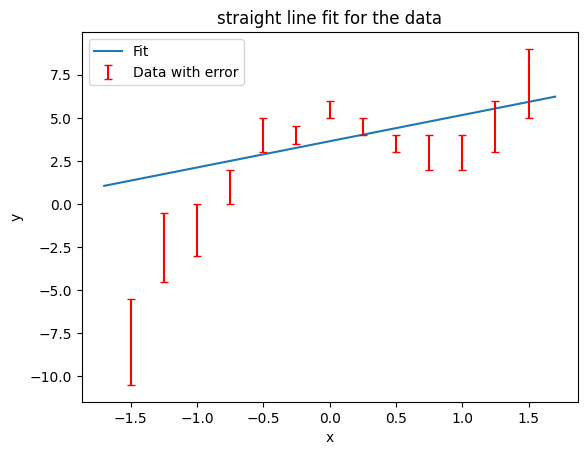

In [99]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a*x+b
popt, pcov=curve_fit(linear, x, y, sigma=sigma_y, absolute_sigma= True)
plt.plot(x_range,linear(x_range,*popt), label='Fit')
plt.errorbar(x,y, yerr=sigma_y, fmt='None', ecolor='r', capsize=3, marker='s', mec='black', mfc='black', ms='2', label='Data with error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('straight line fit for the data')
plt.legend()

print("a=",popt[0], ", Standardfehler=", np.sqrt(pcov[0][0]))
print("b=",popt[1], ", Standardfehler=", np.sqrt(pcov[1][1]))

# p-value
from scipy.stats import chi2
y_fit=linear(x, *popt)
chi_squard=np.sum((y-y_fit)**2/sigma_y**2)
dof = len(x) - len(popt)  # Freiheitsgrade
#print(dof)
p = 1 - chi2.cdf(chi_squard, dof)
print('p=', p)

the probability of obtaining a $\chi^2$-value larger than the observed $\chi^2$ value is very small ($p\ll0.05$), the hypothesis that the model used describes the data can thus be rejected.

f) How does the $p$-value for a straight-line fit change if the error bars are twice as high in this example? Would you say the fit is describing the data well in this case?

11
p= 0.22430487328826554
chi^2= 14.159279625407526
chi_red^2= 0.11701883987940104


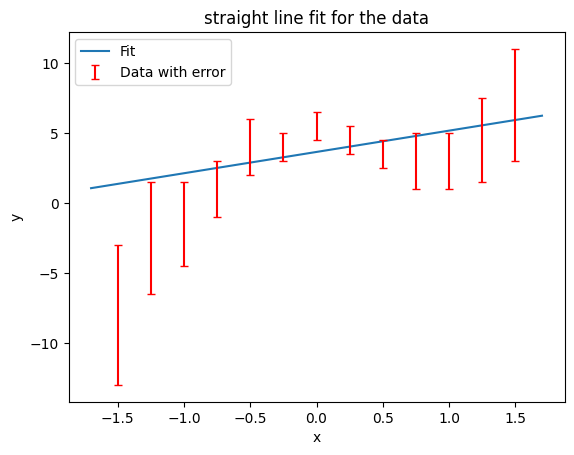

In [104]:
sigma_y2=sigma_y*2

popt2, pcov2=curve_fit(linear, x, y, sigma=sigma_y2, absolute_sigma= True)
popt, pcov=curve_fit(linear, x, y, sigma=sigma_y2, absolute_sigma= True)
plt.plot(x_range,linear(x_range,*popt2), label='Fit')
plt.errorbar(x,y, yerr=sigma_y2, fmt='None', ecolor='r', capsize=3, marker='s', mec='black', mfc='black', ms='2', label='Data with error')
plt.xlabel('x')
plt.ylabel('y')
plt.title('straight line fit for the data')
plt.legend()

y_fit2=linear(x, *popt2)
chi_squard2=np.sum((y-y_fit2)**2/sigma_y2**2)
dof2 = len(x) - len(popt2)  # Freiheitsgrade
print(dof2)
p = 1 - chi2.cdf(chi_squard2, dof2)
print('p=', p)
print('chi^2=', chi_squard2)

# reduced chi value
chi_red=chi_squard2/dof2**2
print('chi_red^2=', chi_red)

The value of p changes to 0.223 (greater than 0.05) when the error bars are doubled in the example. Although this seems to be acceptable, the reduced chi-squared value is calculated as $\chi_{red}^2 = 0.12$, which is much smaller than the expected value of 1. As the script mentions, if the value is significantly different from 1, this can be due to several reasons:

i) the used model is wrong or insufficient

ii) the Gaussian statistic for the distribution of uncertainties is an
incorrect assumption

iii) there are unconsidered systematic uncertainties

iv) the assumed standard deviation $\sigma$ is too large ($\chi$ becomes too small) or too small ($\chi$ becomes too large)

compared to what we have before we can say the incompatibility of the modell has been reduced since the adjusted error bars become larger.